In [2]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv()

False

In [6]:
# Assuming that we are currently in the notebooks directory
from pathlib import Path


project_path = Path.cwd().parent

In [13]:
CKPT_PATH = f'{project_path}/models/chexnet_densenet_121.tar'
N_CLASSES = 14
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
DATA_DIR = os.environ.get('DATA_PATH')
BATCH_SIZE = 64


In [14]:
class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121()
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [15]:
cudnn.benchmark = True

# initialize and load the model
model = DenseNet121(N_CLASSES)
model = torch.nn.DataParallel(model)

if os.path.isfile(CKPT_PATH):
    print("=> loading checkpoint")
    checkpoint = torch.load(CKPT_PATH, map_location=torch.device('cpu'))

    # Renaming keys
    statedict_renamed = {}
    for key, value in checkpoint['state_dict'].items():
        # Substitute the found pattern with just the digits part
        # new_key = re.sub(r'norm(\.\d+)\.', lambda x: x.group(0)[1:], key)
        new_key = re.sub(r'(norm|conv)(\.\d+)\.', lambda x: re.sub(r'\.', '', x.group(0), count=1), key)
        statedict_renamed[new_key] = value
    checkpoint['state_dict'] = statedict_renamed

    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint")
else:
    print("=> no checkpoint found")

=> loading checkpoint
=> loaded checkpoint


In [16]:
def visualise_weights(weights):
    # Expecting input in (N, C, H, W)
    
    # reshape the data in (N, H, W, C)
    weights = weights.transpose(0, 2, 3, 1)

    # Normalize the weights for better visualization
    min_val = np.min(weights)
    max_val = np.max(weights)
    weights = (weights - min_val) / (max_val - min_val)

    # Number of kernels in the first layer
    num_kernels = weights.shape[0]

    # Set up the figure size depending on the number of kernels
    fig, axs = plt.subplots(nrows=int(np.sqrt(num_kernels)), ncols=int(np.sqrt(num_kernels)), figsize=(10, 10))

    # Flatten the array of axes, for easy looping
    axs = axs.flatten()

    # Plot each kernel
    for i, ax in enumerate(axs):
        # Only plot if there is a kernel to plot (important if num_kernels is not a perfect square)
        if i < num_kernels:
            # Display the kernel
            ax.imshow(weights[i])  # Indexing: [kernel_index, color_channel]
            ax.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

### Visualise weights of conv0 layer of CheXNet

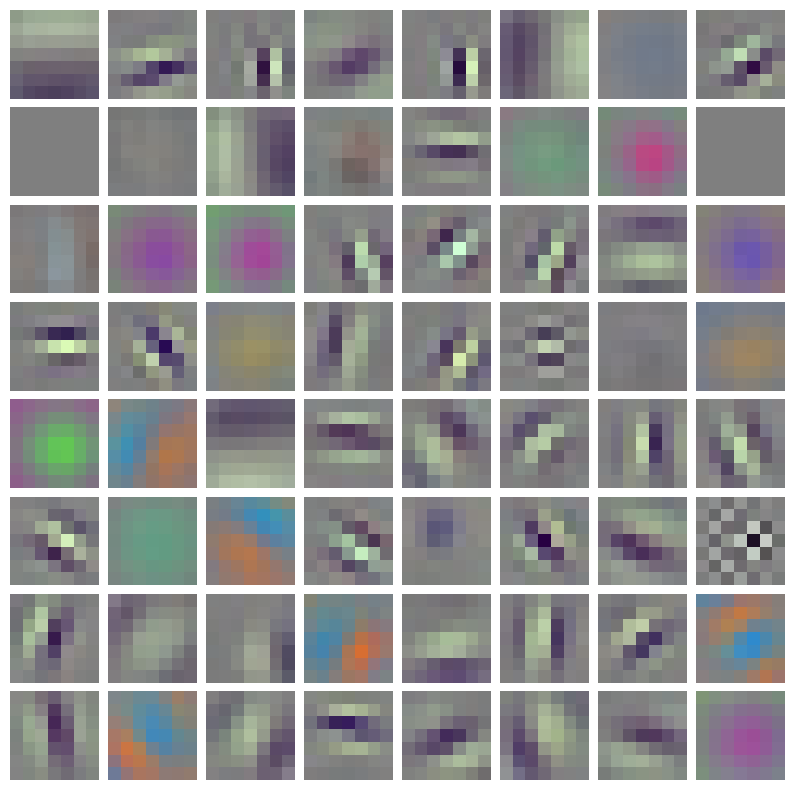

In [17]:
# Assuming 'model' is your ConvNet and it has a first layer named 'conv1'
weights = model.module.densenet121.features.conv0.weight.data.cpu().numpy()

visualise_weights(weights)

### Compare these visualisations with a DenseNet trained on Imagenet